In [1]:
#check if on colab
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !git clone https://github.com/bensapirstein/DeepGraphemics.git
    %cd DeepGraphemics/

our experiments include:

train VAE with latent space dimension 2, 3, 5, 10, 20

train with different hidden layer sizes. (optional)

train VAE on different datasets: "base", "moderate", "rotation" and rich datasets.

train on different letters.

train capsnet with different reconstruction loss weights: 0.0005, 0.005, 0.01, 1, 100

train capsnet with different datasets: "base", "moderate", "rotation" and rich datasets.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os

--- EPOCH 1/1 ---
test_batch (Avg. Loss 27702.289, Accuracy 0.0): 100%|██████████| 1/1 [00:00<00:00, 13.47it/s]
*** Output file ./results/vae_test_run.json written
experiment config:  {'run_name': 'vae_test_run', 'data_dir': 'datasets/raw/base_dataset/', 'letter': 'aleph', 'out_dir': './results', 'seed': 42, 'device': None, 'bs_train': 128, 'bs_test': 128, 'batches': 100, 'epochs': 1, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 1e-05, 'model_type': 'vae', 'model_config': {'latent_dims': 2, 'capacity': 64, 'variational_beta': 1.0}, 'kw': {}}


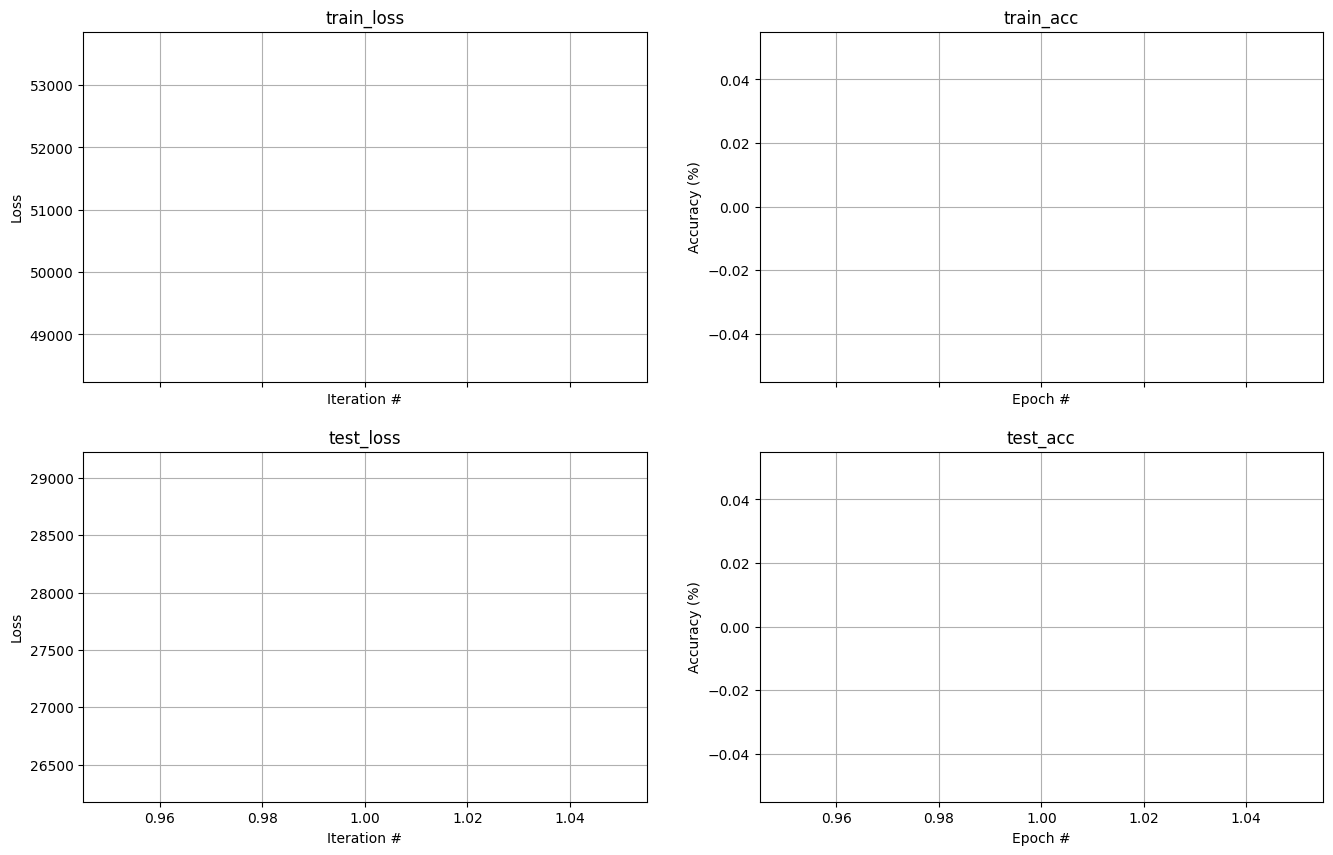

In [10]:
import src.experiments as experiments
from src.experiments import load_experiment
from src.plot import plot_fit
from configs.config import capsnet_config, vae_config
seed = 42

model_type = 'vae'

# model params kwargs
params = vae_config

run_name = f'{model_type}_test_run'
data_dir = 'datasets/raw/base_dataset/'
epochs = 10

# Test experiment implementation on a few data samples and with a small model
experiments.run_experiment(
    run_name, data_dir, letter="aleph", seed=seed, 
    bs_train=128, bs_test=128, epochs=epochs, early_stopping=5,
    model_type=model_type, model_config=params
)

# There should now be a file 'test_run.json' in your `results/` folder.
# We can use it to load the results of the experiment.
cfg, fit_res = load_experiment(f'results/{run_name}.json')
_, _ = plot_fit(fit_res)

# And `cfg` contains the exact parameters to reproduce it
print('experiment config: ', cfg)

In [ ]:
import glob
import re

def plot_exp_results(filename_pattern, results_dir='results'):
    fig = None
    result_files = glob.glob(os.path.join(results_dir, filename_pattern))
    result_files.sort()
    if len(result_files) == 0:
        print(f'No results found for pattern {filename_pattern}.', file=sys.stderr)
        return
    for filepath in result_files:
        m = re.match('exp\d_(\d_)?(.*)\.json', os.path.basename(filepath))
        cfg, fit_res = load_experiment(filepath)
        fig, axes = plot_fit(fit_res, fig, legend=m[2],log_loss=True)
    del cfg['filters_per_layer']
    del cfg['layers_per_block']
    print('common config: ', cfg)

In [22]:
import itertools
from configs.config import dotdict

# hyperparameter search
latent_dims = [2, 3, 5, 10]
capacity = [64, 128]
variational_beta = [0.1, 0.5, 1.0, 2.0]
letters = ["aleph", "shin", "mem"]

for letter, latent_dim, cap, beta in itertools.product(letters, latent_dims, capacity, variational_beta):
    vae_config = dotdict({
        'latent_dims': latent_dim,
        'capacity': cap,
        'variational_beta': beta
    })

    run_name = f"vae_{letter}_{latent_dim}_{cap}_{beta}"
    print(f"Running {letter} experiment with latent_dim={latent_dim}, capacity={cap}, beta={beta}")
    fit_res = experiments.run_experiment(run_name, data_dir, epochs=5, letter=letter, model_type="vae", model_config=vae_config, save_model=True)


Running aleph experiment with latent_dim=2, capacity=64, beta=0.1
--- EPOCH 1/5 ---
test_batch (Avg. Loss 12401.931, Accuracy 0.0): 100%|██████████| 3/3 [00:00<00:00, 44.20it/s]
--- EPOCH 2/5 ---
test_batch (Avg. Loss 9742.018, Accuracy 0.0): 100%|██████████| 3/3 [00:00<00:00, 49.41it/s]
--- EPOCH 3/5 ---
test_batch (Avg. Loss 5888.819, Accuracy 0.0): 100%|██████████| 3/3 [00:00<00:00, 53.64it/s]
--- EPOCH 4/5 ---
test_batch (Avg. Loss 5146.688, Accuracy 0.0): 100%|██████████| 3/3 [00:00<00:00, 52.07it/s]
--- EPOCH 5/5 ---
test_batch (Avg. Loss 4470.000, Accuracy 0.0): 100%|██████████| 3/3 [00:00<00:00, 52.29it/s]
*** Model file ./results/models/vae_aleph_2_64_0.1.pt written
*** Output file ./results/vae_aleph_2_64_0.1.json written
Running shin experiment with latent_dim=2, capacity=64, beta=0.1
--- EPOCH 1/5 ---
test_batch (Avg. Loss 11642.134, Accuracy 0.0): 100%|██████████| 3/3 [00:00<00:00, 36.64it/s]
--- EPOCH 2/5 ---
test_batch (Avg. Loss 6805.725, Accuracy 0.0): 100%|██████████|

KeyboardInterrupt: 